In [96]:
import numpy as np
import pandas as pd
import keras
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt

In [97]:
import os 

cwd = os.getcwd() 
      
# Print the current working 
# directory (CWD) 
os.chdir('/Users/jessicakahn/Documents/Harvard DL/final_project') 
print("Current working directory:", cwd) 

Current working directory: /Users/jessicakahn/Documents/Harvard DL/final_project


In [98]:
# !kaggle datasets download -d engdan/happywhale-images-256-by-256
!ls

ArcFace.ipynb                        model1_0801.keras
Final Project HappyWhale local.ipynb resized_test_images
data_exploration.ipynb               resized_train_images
happywhale-images-256-by-256.zip     train.csv


In [101]:
train_ids = pd.read_csv('train.csv')

In [102]:
train_dir = 'resized_train_images/'
im_list = os.listdir(train_dir)
train_df = pd.DataFrame(im_list, columns=['image'])
train_df = train_df.merge(train_ids, on='image', how='left')
train_df["image_path"] = train_df["image"].apply(lambda x: train_dir + "/" + x)

In [104]:
# train_df.head()

In [105]:
from pathlib import Path

def make_folders(path):
    """
    This function creates separate folders for each unique id,
    which will have 1 or more images per folder
    """
    mappings = train_df.groupby('species')['image'].apply(list).to_dict()
    for folder, file_list in mappings.items():
        for imfile in file_list:
            imfile = Path(path.joinpath(imfile))
            Path(path.joinpath(folder)).mkdir(parents=True, exist_ok=True)
            path = Path(path.joinpath())
            try:
                imfile.rename(path / folder / imfile.name)
            except FileNotFoundError:
                print(f"Couldn't find {imfile.stem} in source folder")

In [106]:
train_path = Path(train_dir)
make_folders(train_path)

In [172]:
def plot_history(history, nepochs, metric):
    """ Helper function to plot accuracy or loss """
    train_acc = history.history[metric]
    test_acc = history.history['val_'+metric]

    plt.figure(figsize=(16,6))
    plt.plot(range(1,nepochs+1), train_acc, 'b', label='train'+metric,color="blue")
    plt.plot(range(1,nepochs+1), test_acc, 'b', label='test'+metric,color="red")

    #plt.ylim((0, 0.0001))
    plt.title('CNN: max(val_{}) = '.format(metric) + str(round(max(test_acc),6)),fontsize=16)
    plt.xlabel('Epochs',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.legend(loc = 'upper right',fontsize=16)
    # plt.ylim(0,0.06)

    plt.show()

### Species Model

In [141]:
train_datagen = ImageDataGenerator(
                                # preprocessing_function=preprocess_input_vgg,
                                rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)  # val 20%


train_data = train_datagen.flow_from_directory(train_dir, 
                                               target_size=(128, 128), 
                                            #    color_mode='rgb',
                                               batch_size=32, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset = 'training') 

val_data = train_datagen.flow_from_directory(train_dir, 
                                           target_size=(128, 128), 
                                        #    color_mode='rgb',
                                           batch_size=32, 
                                           class_mode='categorical',
                                           shuffle=True,
                                           subset = 'validation')

Found 40839 images belonging to 30 classes.
Found 10194 images belonging to 30 classes.


In [142]:
len(val_data.class_indices)

30

In [240]:
# Build species model architecture
model = Sequential()

model.add(Conv2D(filters=32, kernel_size = (3,3), strides = (1, 1), input_shape = (128, 128, 3)))
model.add(BatchNormalization(axis = 3))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(filters=64, kernel_size = (3, 3), strides = (1,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3)))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(30, activation='softmax')) # Number of species

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()


Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_126 (Conv2D)         (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_65 (Ba  (None, 126, 126, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_89 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_80 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_127 (Conv2D)         (None, 61, 61, 64)        18496     
                                                                 
 activation_90 (Activation)  (None, 61, 61, 64)      

In [241]:
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['acc'])

In [ ]:
n = 300
history = model.fit(
      train_data,
      # steps_per_epoch=100,
      epochs=n,
      validation_data=val_data
      # ,validation_steps=50
      )

In [247]:
len(history.history['accuracy'])

300

In [ ]:
model.save('species_model2.keras')

In [27]:
# im_list

/var/folders/4j/5szy6qkj5m96kf2gjwkk0dv80000gn/T/ipykernel_77283/3134269840.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_acc, 'b', label='train'+metric,color="blue")
/var/folders/4j/5szy6qkj5m96kf2gjwkk0dv80000gn/T/ipykernel_77283/3134269840.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_acc, 'b', label='test'+metric,color="red")


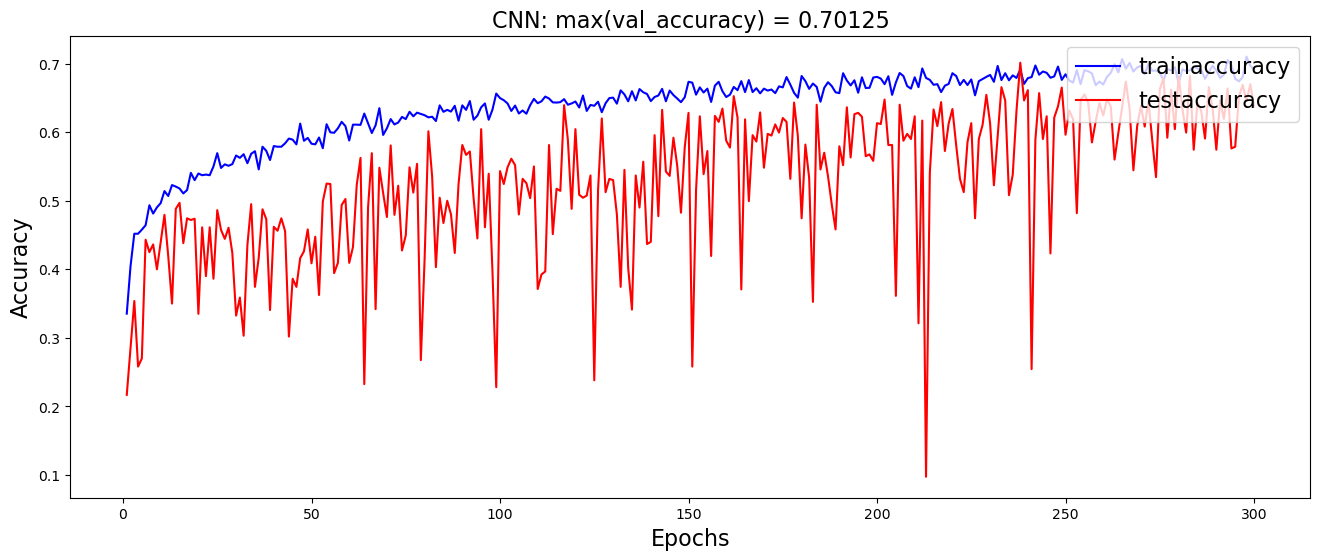

In [177]:
plot_history(history, n, 'accuracy')

In [178]:
predictions = model.predict(val_data)

319/319 [==============================] - 28s 87ms/step


In [181]:
from sklearn.metrics import confusion_matrix, classification_report

319/319 [==============================] - 27s 84ms/step

Test Accuracy : 64.24%



/Users/jessicakahn/miniconda3/envs/Assignment1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jessicakahn/miniconda3/envs/Assignment1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jessicakahn/miniconda3/envs/Assignment1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

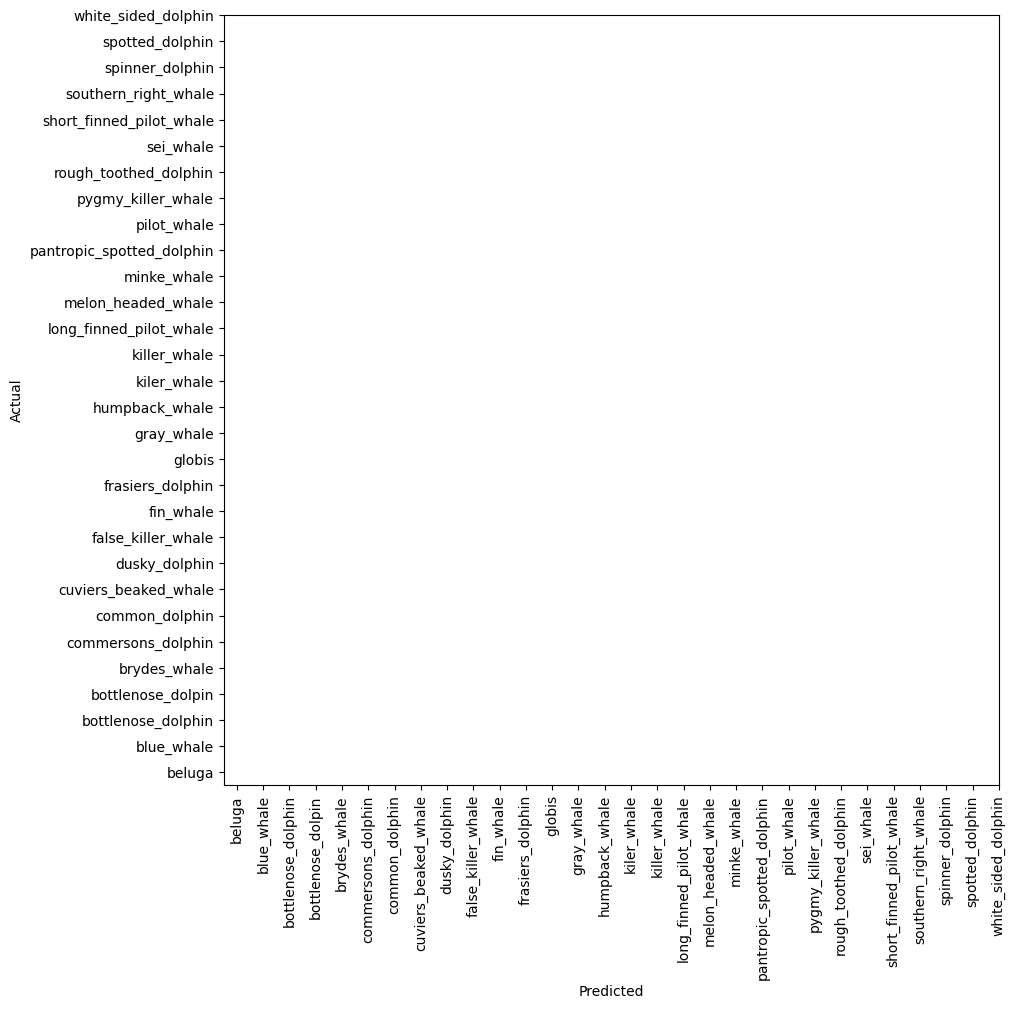

classification Report------------>
                           precision    recall  f1-score   support

                   beluga       0.16      0.16      0.16      1488
               blue_whale       0.10      0.07      0.08       966
       bottlenose_dolphin       0.21      0.28      0.24      1932
        bottlenose_dolpin       0.03      0.03      0.03       223
             brydes_whale       0.00      0.00      0.00        30
       commersons_dolphin       0.00      0.00      0.00        18
           common_dolphin       0.00      0.00      0.00        69
     cuviers_beaked_whale       0.00      0.00      0.00        68
            dusky_dolphin       0.05      0.06      0.06       627
       false_killer_whale       0.08      0.09      0.08       665
                fin_whale       0.02      0.01      0.01       264
         frasiers_dolphin       0.00      0.00      0.00         2
                   globis       0.00      0.00      0.00        23
               gray_whale 

In [184]:
results = model.evaluate(val_data, verbose = 0)
pred = np.argmax(model.predict(val_data), axis = 1)
class_names = list(val_data.class_indices.keys())
cm = confusion_matrix(val_data.labels, pred, labels = np.arange(30))
clr = classification_report(val_data.labels, pred, labels = np.arange(30),target_names = class_names)
# print(f'\nTest Accuracy : {round(results[1], 4)*100}%\n')


In [219]:
df = pd.DataFrame(list(val_data.labels), columns=['label'])

In [225]:
inv_map = {v: k for k, v in val_data.class_indices.items()}

In [226]:
df['class'] = df['label'].map(inv_map)

In [228]:
df.groupby('class').count().sort_values

,label
class,
beluga,1488
blue_whale,966
bottlenose_dolphin,1932
bottlenose_dolpin,223
brydes_whale,30
commersons_dolphin,18
common_dolphin,69
cuviers_beaked_whale,68
dusky_dolphin,627


In [224]:
pd.DataFrame.from_dict(val_data.class_indices)

ValueError: If using all scalar values, you must pass an index

Text(0.5, 1.0, 'Confusion matrix')

<Figure size 2500x2500 with 0 Axes>

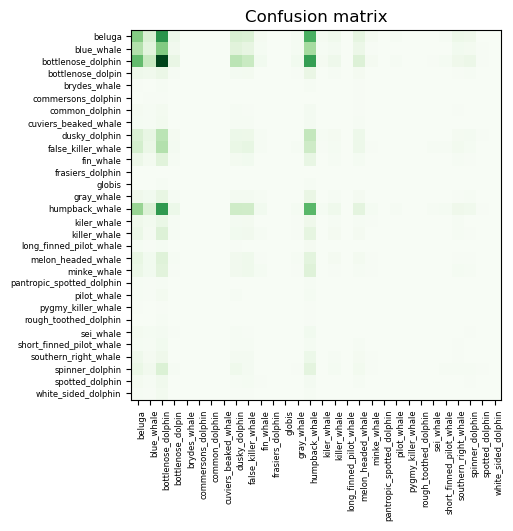

In [236]:
# !pip install seaborn
plt.figure(figsize=(25,25))
fig, ax = plt.subplots()
im = ax.imshow(cm,cmap='Greens', interpolation='nearest')
ax = plt.gca();

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(30), labels=class_names, fontsize=6)
ax.set_yticks(np.arange(30), labels=class_names,fontsize=6)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation='vertical', ha="right",
         rotation_mode="anchor")

ax.grid(which='minor', color='yellow', linestyle='-', linewidth=2)
ax.set_title("Confusion matrix")
# ax.cbar_axes[1].colorbar(im)
# colorbar()
# fig.tight_layout()
# plt.show()

In [189]:
# import seaborn

In [255]:
# plt.figure(figsize = (10,10))
# # sns.heatmap(cm, annot = True, fmt = 'g', vmin = 0, cbar = False)
# plt.xticks(ticks = np.arange(30) + 0.5, labels = class_names, rotation = 90)
# plt.yticks(ticks = np.arange(30) + 0.5, labels = class_names, rotation = 0)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()
print(clr)

                           precision    recall  f1-score   support

                   beluga       0.16      0.16      0.16      1488
               blue_whale       0.10      0.07      0.08       966
       bottlenose_dolphin       0.21      0.28      0.24      1932
        bottlenose_dolpin       0.03      0.03      0.03       223
             brydes_whale       0.00      0.00      0.00        30
       commersons_dolphin       0.00      0.00      0.00        18
           common_dolphin       0.00      0.00      0.00        69
     cuviers_beaked_whale       0.00      0.00      0.00        68
            dusky_dolphin       0.05      0.06      0.06       627
       false_killer_whale       0.08      0.09      0.08       665
                fin_whale       0.02      0.01      0.01       264
         frasiers_dolphin       0.00      0.00      0.00         2
                   globis       0.00      0.00      0.00        23
               gray_whale       0.01      0.00      0.01     

In [122]:
model.save('species_model1.keras')
# !pwd

In [146]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ReLU, LeakyReLU, Dropout
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [147]:
len(val_data.class_indices)

30

In [27]:
model=Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding='valid',input_shape=(128,128, 3)))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(alpha=0.01)))

model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(1,1), padding='valid'))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(filters=96, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((3, 3)))

model.add(Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), padding='valid'))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(alpha=0.01)))

model.add(Conv2D(filters=len(val_data.class_indices), kernel_size=(2,2), strides=(1,1), padding='valid'))
model.add(Activation('softmax'))
model.add(Flatten())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 124, 124, 32)      2432      
                                                                 
 batch_normalization (Batch  (None, 124, 124, 32)      128       
 Normalization)                                                  
                                                                 
 activation_3 (Activation)   (None, 124, 124, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 41, 41, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 38, 38, 64)        32832     
                                                                 
 batch_normalization_1 (Bat  (None, 38, 38, 64)       

In [28]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [29]:
history = model.fit(
      train_data,
      steps_per_epoch=100,
      epochs=100,
      validation_data=val_data
      ,validation_steps=50
      )

Epoch 1/100
100/100 [==============================] - 69s 680ms/step - loss: 9.4843 - acc: 0.0050 - val_loss: 8.2681 - val_acc: 0.0437
Epoch 2/100
100/100 [==============================] - 62s 623ms/step - loss: 9.0938 - acc: 0.0100 - val_loss: 7.8256 - val_acc: 0.0406
Epoch 3/100
100/100 [==============================] - 54s 536ms/step - loss: 8.9212 - acc: 0.0078 - val_loss: 7.6560 - val_acc: 0.0456
Epoch 4/100
100/100 [==============================] - 57s 566ms/step - loss: 8.7088 - acc: 0.0103 - val_loss: 7.2586 - val_acc: 0.0512
Epoch 5/100
100/100 [==============================] - 54s 543ms/step - loss: 8.6712 - acc: 0.0109 - val_loss: 7.2489 - val_acc: 0.0469
Epoch 6/100
100/100 [==============================] - 57s 573ms/step - loss: 8.6290 - acc: 0.0128 - val_loss: 7.2925 - val_acc: 0.0463
Epoch 7/100
100/100 [==============================] - 61s 609ms/step - loss: 8.5987 - acc: 0.0128 - val_loss: 7.2298 - val_acc: 0.0300
Epoch 8/100
100/100 [===========================

In [30]:
model.save('model1_0801.keras')

/var/folders/4j/5szy6qkj5m96kf2gjwkk0dv80000gn/T/ipykernel_77283/2886583412.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,100+1), train_acc, 'b', label='train acc',color="blue")
/var/folders/4j/5szy6qkj5m96kf2gjwkk0dv80000gn/T/ipykernel_77283/2886583412.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,100+1), test_acc, 'b', label='test acc',color="red")


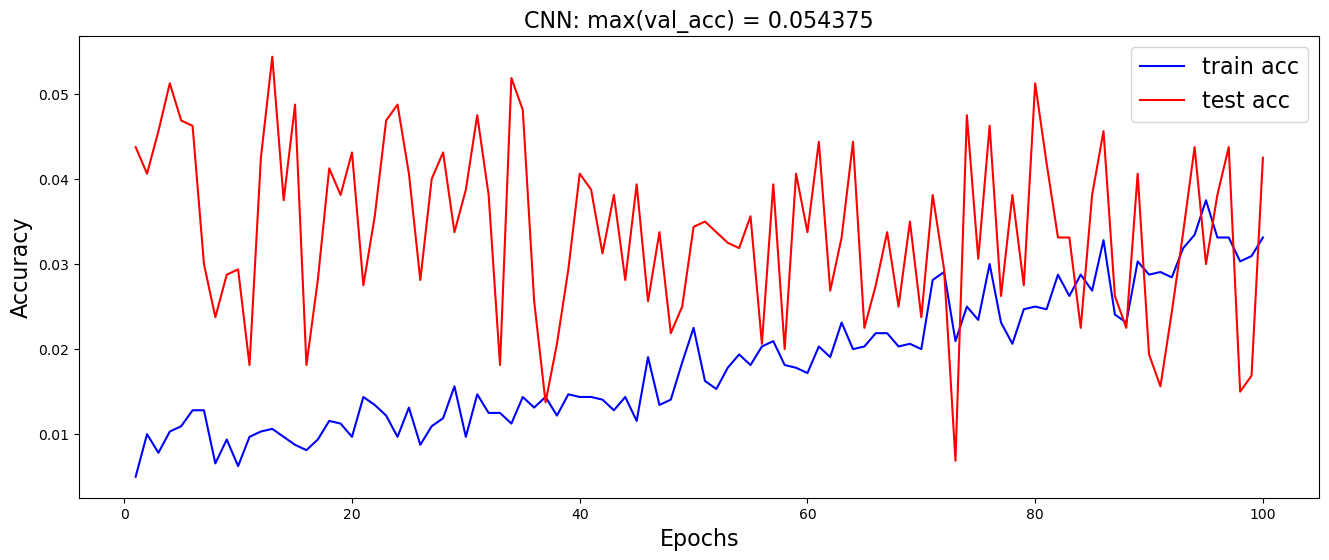

In [35]:
plot_history(history)

### Accuracy not looking good - let's try increasing the size and adding another conv2d layer

In [39]:
train_datagen2 = ImageDataGenerator(
                                # preprocessing_function=preprocess_input_vgg,
                                rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)  # val 20%


train_data2 = train_datagen.flow_from_directory(train_dir, 
                                               target_size=(256, 256), 
                                            #    color_mode='rgb',
                                               batch_size=32, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset = 'training') 

val_data2 = train_datagen.flow_from_directory(train_dir, 
                                           target_size=(256, 256), 
                                        #    color_mode='rgb',
                                           batch_size=32, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           subset = 'validation')

Found 45535 images belonging to 15587 classes.
Found 5498 images belonging to 15587 classes.


In [44]:
len(val_data2.class_indices)

15587

In [50]:
model_2 = Sequential()
#Convolution layer 1
model_2.add(Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding='valid',input_shape=(256,256, 3)))
model_2.add(BatchNormalization())
model_2.add(Activation(LeakyReLU(alpha=0.01)))

model_2.add(MaxPooling2D((3, 3)))
model_2.add(Conv2D(filters=64, kernel_size=(4,4), strides=(1,1), padding='valid'))
model_2.add(BatchNormalization())
model_2.add(Activation(LeakyReLU(alpha=0.01)))
model_2.add(MaxPooling2D((3, 3)))
#Convolution layer 2
model_2.add(Conv2D(filters=96, kernel_size=(3,3), strides=(1,1), padding='valid'))
model_2.add(BatchNormalization())
model_2.add(Activation(LeakyReLU(alpha=0.01)))
model_2.add(MaxPooling2D((3, 3)))


model_2.add(Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), padding='valid'))
model_2.add(BatchNormalization())
model_2.add(Activation(LeakyReLU(alpha=0.01)))

model_2.add(Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), padding='valid'))
model_2.add(Activation('softmax'))
model_2.add(Flatten())
model_2.add(Dense(len(val_data2.class_indices), activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 252, 252, 32)      2432      
                                                                 
 batch_normalization_32 (Ba  (None, 252, 252, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_43 (Activation)  (None, 252, 252, 32)      0         
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 84, 84, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_56 (Conv2D)          (None, 81, 81, 64)        32832     
                                                                 
 batch_normalization_33 (Ba  (None, 81, 81, 64)      

In [51]:
history2 = model_2.fit(
      train_data2,
      steps_per_epoch=100,
      epochs=100,
      validation_data=val_data
      ,validation_steps=50
    , verbose=1
      )

Epoch 1/100
100/100 [==============================] - 202s 2s/step - loss: 15.9850 - accuracy: 6.2500e-04 - val_loss: 15.9554 - val_accuracy: 0.0000e+00
Epoch 2/100
100/100 [==============================] - 191s 2s/step - loss: 16.0159 - accuracy: 3.1250e-04 - val_loss: 15.9564 - val_accuracy: 0.0000e+00
Epoch 3/100
100/100 [==============================] - 194s 2s/step - loss: 16.0218 - accuracy: 0.0016 - val_loss: 15.9542 - val_accuracy: 0.0000e+00
Epoch 4/100
100/100 [==============================] - 204s 2s/step - loss: 16.0336 - accuracy: 6.2500e-04 - val_loss: 15.9517 - val_accuracy: 0.0000e+00
Epoch 5/100
100/100 [==============================] - 202s 2s/step - loss: 16.0117 - accuracy: 6.2520e-04 - val_loss: 15.9486 - val_accuracy: 0.0000e+00
Epoch 6/100
100/100 [==============================] - 201s 2s/step - loss: 16.0357 - accuracy: 0.0019 - val_loss: 15.9406 - val_accuracy: 0.0044
Epoch 7/100
100/100 [==============================] - 208s 2s/step - loss: 16.0082 - ac

/var/folders/4j/5szy6qkj5m96kf2gjwkk0dv80000gn/T/ipykernel_77283/2118417375.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,100+1), train_acc, 'b', label='train acc',color="blue")
/var/folders/4j/5szy6qkj5m96kf2gjwkk0dv80000gn/T/ipykernel_77283/2118417375.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,100+1), test_acc, 'b', label='test acc',color="red")


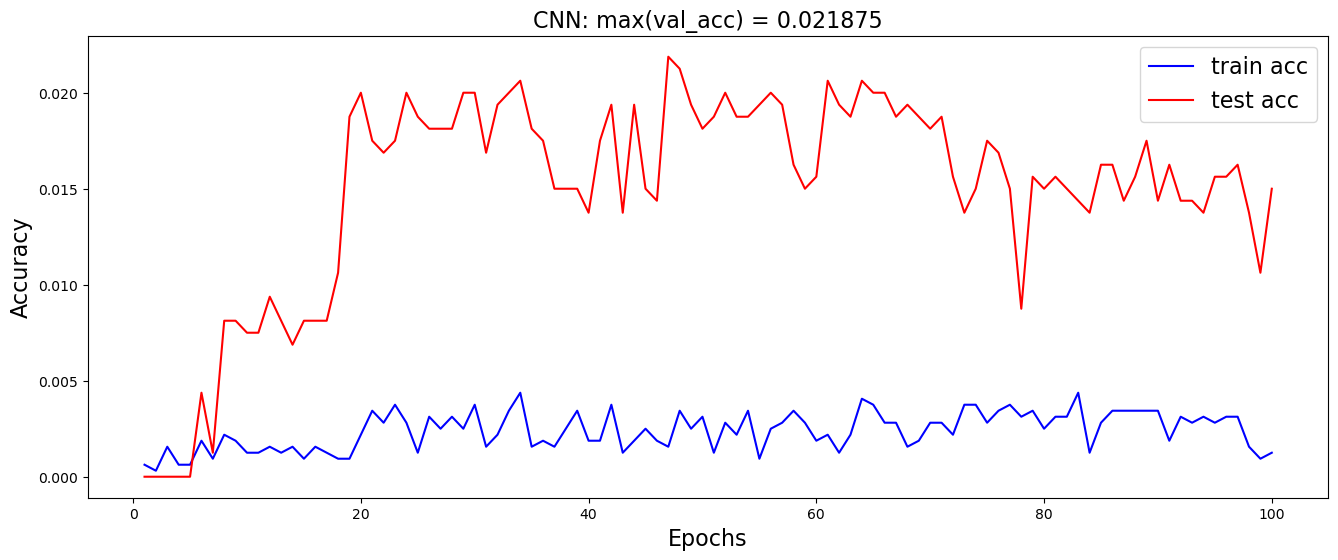

In [54]:
train_acc = history2.history['accuracy']
test_acc = history2.history['val_accuracy']

plt.figure(figsize=(16,6))
plt.plot(range(1,100+1), train_acc, 'b', label='train acc',color="blue")
plt.plot(range(1,100+1), test_acc, 'b', label='test acc',color="red")

#plt.ylim((0, 0.0001))
plt.title('CNN: max(val_acc) = ' + str(round(max(test_acc),6)),fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.legend(loc = 'upper right',fontsize=16)
# plt.ylim(0,0.06)

plt.show()

In [56]:
# Try transfer learning
# I ended up running this code in the final_project notebook on Kaggle as it 
# was very slow on my local machine

In [69]:
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

In [63]:
train_datagen2 = ImageDataGenerator(
                                preprocessing_function=preprocess_input_vgg,
                                rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)  # val 20%


train_data2 = train_datagen2.flow_from_directory(train_dir, 
                                               target_size=(128, 128), 
                                            #    color_mode='rgb',
                                               batch_size=32, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset = 'training') 

val_data2 = train_datagen2.flow_from_directory(train_dir, 
                                           target_size=(128, 128), 
                                        #    color_mode='rgb',
                                           batch_size=32, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           subset = 'validation')

Found 45535 images belonging to 15587 classes.
Found 5498 images belonging to 15587 classes.


In [55]:
vgg16 = VGG16(weights='imagenet')

In [57]:
x  = vgg16.get_layer('fc2').output
prediction = keras.layers.Dense(15587, activation='softmax', name='predictions')(x)

# model3 = Model(inputs=vgg16.input, outputs=prediction)

In [74]:
conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=(128,128,3))

58889256/58889256 [==============================] - 1s 0us/step


In [77]:
top_model = conv_base.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(4096, activation='relu')(top_model)
top_model = Dense(1072, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
output_layer = Dense(15587, activation='softmax')(top_model)

In [78]:
model3 = Model(inputs=conv_base.input, outputs=output_layer)

In [81]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# batch_size = 32
history = model3.fit(
        train_data2,
        # steps_per_epoch=16,
        # steps_per_epoch=2000 // 
        batch_size=32,
        epochs=4
        ,validation_data=val_data2
        # ,validation_steps=800 // batch_size
        )

In [59]:
for layer in model.layers:
    if layer.name in ['predictions']:
        continue
    layer.trainable = False


df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])

In [260]:
# !pwd

In [256]:
# Visualize activations

In [263]:
# from keras import models
# from keras.models import load_model
# model = load_model('model1_0801.keras')
# model.summary()
# model.save('')
# Extracts the outputs of the top 8 layers:


NameError: name 'activations' is not defined

NameError: name 'first_layer_activation' is not defined